# Optimal Transport 

## Overview

The **transportation** or **optimal transport** problem is interesting both
because of its many applications and because of its important role in the history of
economic theory.

In this lecture, we describe the problem, tell how 
{doc}`linear programming <lp_intro>` is a
key tool for solving it, and then provide some examples.  

We will provide other applications in followup lectures.

The optimal transport problem was studied in early work about linear
programming, as summarized for example by {cite}`DoSSo`.  A modern reference
about applications in economics is {cite}`Galichon_2016`.

Below, we show how to solve the optimal transport problem using
several implementations of linear programming, including, in order,

1. the
   [linprog](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html)
   solver from SciPy, 
2. the [linprog_simplex](https://quanteconpy.readthedocs.io/en/latest/optimize/linprog_simplex.html) solver from QuantEcon and
3. the simplex-based solvers included in the [Python Optimal Transport](https://pythonot.github.io/) package.

In [1]:
!pip install --upgrade quantecon
!pip install --upgrade POT jax jaxlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/670.2 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 kB 15.7 MB/s eta 0:00:00


Let's start with some imports.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from quantecon.optimize.linprog_simplex import linprog_simplex
import ot
from scipy.stats import binom, betabinom
import networkx as nx

## The Optimal Transport Problem

Suppose that $m$ factories produce goods that must be sent to $n$ locations.

Let 

* $x_{ij}$ denote the quantity  shipped from factory $i$ to location  $j$

* $c_{ij}$ denote the cost of shipping one unit  from factory $i$ to location $j$

* $p_i$ denote the capacity of factory $i$ and $q_j$ denote the amount required at location $j$. 

*  $i = 1, 2, \dots, m$ and $j = 1, 2, \dots, n$.

A planner wants to minimize  total transportation costs subject to the following constraints:

* The amount shipped **from** each factory must equal  its capacity.

* The amount shipped **to** each location must equal the quantity required there.


The figure below shows one visualization of this idea, when factories and
target locations are distributed in the plane.

```{figure} /_static/lecture_specific/opt_transport/optimal_transport_splitting_experiment.png

```

The size of the vertices in the figure are proportional to 

- capacity, for the factories, and
- demand (amount required) for the target locations.

The arrows show one possible transport plan, which respects the constraints
stated above.


The planner's problem can be expressed as the following constrained minimization problem:

$$
\begin{aligned}
    \min_{x_{ij}} \ & \sum_{i=1}^m \sum_{j=1}^n c_{ij} x_{ij} \\
    \mbox{subject to } \ & \sum_{j=1}^n x_{ij} = p_i, & i = 1, 2, \dots, m \\
    & \sum_{i=1}^m x_{ij} = q_j, & j = 1, 2, \dots, n \\
    & x_{ij} \ge 0 \\
\end{aligned}
$$ (plannerproblem)

This is an **optimal transport problem** with

* $mn$ decision variables, namely, the entries $x_{ij}$   and

* $m+n$ constraints.

Summing the $q_j$'s across all $j$'s and the $p_i$'s across all $i$'s indicates that the total capacity of all the factories  equals  total requirements at all locations: 

$$
    \sum_{j=1}^n q_j 
    = \sum_{j=1}^n \sum_{i=1}^m x_{ij} 
    = \sum_{i=1}^m \sum_{j=1}^n x_{ij} 
    = \sum_{i=1}^m p_i
$$ (sumconstraints)

The presence of the restrictions in {eq}`sumconstraints` will be the source of
one redundancy in the complete set of restrictions that we describe below.  

More about this later.




## The Linear Programming Approach

In this section we discuss using using standard linear programming solvers to
tackle the optimal transport problem.


### Vectorizing a Matrix of Decision Variables

A *matrix* of decision variables $x_{ij}$ appears in problem {eq}`plannerproblem`. 

The SciPy function `linprog` expects to see a *vector* of decision variables. 

This situation impels us to rewrite our problem in terms of a
*vector* of decision variables.

Let 

* $X, C$ be $m \times n$ matrices with entries $x_{ij}, c_{ij}$,

* $p$ be $m$-dimensional vector with entries $p_i$,

* $q$ be $n$-dimensional vector with entries $q_j$. 

With $\mathbf{1}_n$ denoting the $n$-dimensional column vector $(1, 1, \dots,
1)'$, our  problem can now be expressed compactly as:

$$
\begin{aligned}
    \min_{X} \ & \operatorname{tr} (C' X) \\
    \mbox{subject to } \ & X \ \mathbf{1}_n = p \\
    & X' \ \mathbf{1}_m = q \\
    & X \ge 0 \\
\end{aligned}
$$

We can convert the matrix $X$ into a vector by stacking all of its columns into a  column vector. 

Doing this is called **vectorization**, an operation that we denote  $\operatorname{vec}(X)$. 

Similarly, we convert the matrix $C$ into an $mn$-dimensional vector $\operatorname{vec}(C)$.

The objective function can be expressed as the inner product between $\operatorname{vec}(C)$ and $\operatorname{vec}(X)$:

$$
    \operatorname{vec}(C)' \cdot \operatorname{vec}(X).
$$

To express the constraints in terms of $\operatorname{vec}(X)$, we use a
**Kronecker product** denoted by $\otimes$ and defined as follows.

Suppose $A$ is an $m \times s$ matrix with entries $(a_{ij})$ and that $B$ is
an $n \times t$ matrix.

The **Kronecker product** of $A$ and $B$ is defined, in block matrix form, by

$$
    A \otimes B = 
    \begin{pmatrix}
    a_{11}B & a_{12}B & \dots & a_{1s}B \\ 
    a_{21}B & a_{22}B & \dots & a_{2s}B \\ 
      &   & \vdots &   \\ 
    a_{m1}B & a_{m2}B & \dots & a_{ms}B \\ 
    \end{pmatrix}.
$$

$A \otimes B$ is an $mn \times st$ matrix.

It has the property that for any $m \times n$ matrix $X$

$$
    \operatorname{vec}(A'XB) = (B' \otimes A') \operatorname{vec}(X).
$$ (kroneckerprop)

We can now express our constraints in terms of $\operatorname{vec}(X)$.

Let $A = \mathbf{I}_m', B = \mathbf{1}_n$.

By equation {eq}`kroneckerprop`

$$
    X \ \mathbf{1}_n 
    = \operatorname{vec}(X \ \mathbf{1}_n) 
    = \operatorname{vec}(\mathbf{I}_m X \ \mathbf{1}_n) 
    = (\mathbf{1}_n' \otimes \mathbf{I}_m) \operatorname{vec}(X).
$$

where  $\mathbf{I}_m$ denotes the $m \times m$ identity matrix.

Constraint $X \ \mathbf{1}_n = p$ can now be written as:

$$
    (\mathbf{1}_n' \otimes \mathbf{I}_m) \operatorname{vec}(X) = p.
$$

Similarly, the constraint $X' \ \mathbf{1}_m = q$ can be rewriten as:

$$
    (\mathbf{I}_n \otimes \mathbf{1}_m') \operatorname{vec}(X) = q.
$$

With $z := \operatorname{vec}(X)$, our problem can now be expressed
in terms of an $mn$-dimensional vector of decision variables:

$$
    \begin{aligned}
        \min_{z} \ & \operatorname{vec}(C)' z \\
        \mbox{subject to } \ & A z = b \\
        & z \ge 0 \\
    \end{aligned}
$$ (decisionvars)

where

$$
    A = 
    \begin{pmatrix}
        \mathbf{1}_n' \otimes \mathbf{I}_m \\ 
        \mathbf{I}_n \otimes \mathbf{1}_m' \\ 
    \end{pmatrix}
    \quad \text{and} \quad
    b = \begin{pmatrix} 
            p \\ 
            q \\ 
        \end{pmatrix}
$$


### An Application


We now provide an example that takes the form {eq}`decisionvars` that we'll
solve by deploying the function `linprog`.

The table below provides numbers for the requirements vector $q$, the capacity vector $p$,
and entries $c_{ij}$  of the cost-of-shipping matrix $C$.


```{raw} html
<table>
    <tr>
	    <th> </th>
        <th colspan="3"><center>Factory</center></th>
	    <th rowspan="2">Requirement</th>  
	</tr >
    <tr>
        <th> Location </th> <th>1</th> <th>2</th> <th>3</th>
	</tr>
    <tr>
	    <td>1</td>  <td>10</td> <td>20</td> <td>30</td> <td>25</td>
	</tr>
    <tr>
	    <td>2</td> <td>15</td> <td>40</td> <td>35</td> <td>115</td>
	</tr>
    <tr>
	    <td>3</td> <td>20</td> <td>15</td> <td>40</td> <td>60</td>
	</tr>
    <tr>
	    <td>4</td> <td>20</td> <td>30</td> <td>55</td> <td>30</td>
	</tr>
    <tr>
	    <td>5</td> <td>40</td> <td>30</td> <td>25</td> <td>70</td>
	</tr>
    <tr>
	    <td>Capacity</td> <td>50</td> <td>100</td> <td>150</td> <td>300</td>
	</tr>
</table>
```

The numbers in the above table tell us to set $m = 3$, $n = 5$, and construct
the following objects:

$$
p = \begin{pmatrix}
        50 \\
        100 \\
        150 
    \end{pmatrix},
    \quad
    q = 
    \begin{pmatrix}
        25 \\
        115 \\
        60 \\
        30 \\
        70
    \end{pmatrix}
    \quad \text{and} \quad
    C = 
    \begin{pmatrix}
        10 &15 &20 &20 &40 \\
        20 &40 &15 &30 &30 \\
        30 &35 &40 &55 &25 
    \end{pmatrix}.
$$

Let's write Python code that sets up the problem and solves it.

In [3]:
# Define parameters
m = 3
n = 5

p = np.array([50, 100, 150])
q = np.array([25, 115, 60, 30, 70])

C = np.array([[10, 15, 20, 20, 40],
              [20, 40, 15, 30, 30],
              [30, 35, 40, 55, 25]])

# Vectorize matrix C
C_vec = C.reshape((m*n, 1), order='F')

# Construct matrix A by Kronecker product
A1 = np.kron(np.ones((1, n)), np.identity(m))
A2 = np.kron(np.identity(n), np.ones((1, m)))
A = np.vstack([A1, A2])

# Construct vector b
b = np.hstack([p, q])

# Solve the primal problem
res = linprog(C_vec, A_eq=A, b_eq=b, method='Revised simplex')

# Print results
print("message:", res.message)
print("nit:", res.nit)
print("fun:", res.fun)
print("z:", res.x)
print("X:", res.x.reshape((m,n), order='F'))

message: Optimization terminated successfully.
nit: 12
fun: 7225.0
z: [15. 10.  0. 35.  0. 80.  0. 60.  0.  0. 30.  0.  0.  0. 70.]
X: [[15. 35.  0.  0.  0.]
 [10.  0. 60. 30.  0.]
 [ 0. 80.  0.  0. 70.]]


/tmp/ipykernel_17085/1014317504.py:24: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(C_vec, A_eq=A, b_eq=b, method='Revised simplex')
/tmp/ipykernel_17085/1014317504.py:24: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = linprog(C_vec, A_eq=A, b_eq=b, method='Revised simplex')


Notice how, in the line `C_vec = C.reshape((m*n, 1), order='F')`, we are
careful to vectorize using the flag `order='F'`.

This is consistent with converting $C$ into a vector by stacking all of its
columns into a  column vector. 

Here `'F'` stands for "Fortran", and we are using Fortran style column-major order.

(For an alternative approach, using Python's default row-major ordering, see [this
        lecture by Alfred
        Galichon](https://www.math-econ-code.org/dynamic-programming).)

**Interpreting the warning:**  

The above warning message from SciPy points out that A is not full rank.

This indicates that the linear program has been set up to include one or more redundant constraints.

Here, the source of the redundancy is the structure of  restrictions {eq}`sumconstraints`.

Let's explore this further by printing out $A$ and staring at it.

In [4]:
A

array([[1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]])

The singularity of $A$ reflects that the  first three constraints and the last five constraints  both require  that "total requirements equal total capacities" expressed in {eq}`sumconstraints`.

One  equality constraint here is redundant.

Below we drop one of the equality constraints, and use only  7 of them.

After doing this, we attain the same minimized cost. 

However, we find a  different transportation plan.

Though it is a different plan, it attains the same cost!

In [5]:
linprog(C_vec, A_eq=A[:-1], b_eq=b[:-1], method='Revised simplex')

/tmp/ipykernel_17085/1219707093.py:1: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  linprog(C_vec, A_eq=A[:-1], b_eq=b[:-1], method='Revised simplex')


     con: array([0., 0., 0., 0., 0., 0., 0.])
     fun: 7225.0
 message: 'Optimization terminated successfully.'
     nit: 13
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([ 0., 25.,  0., 35.,  0., 80.,  0., 60.,  0., 15., 15.,  0.,  0.,
        0., 70.])

In [6]:
%time linprog(C_vec, A_eq=A[:-1], b_eq=b[:-1], method='Revised simplex')

CPU times: user 4.6 ms, sys: 67 µs, total: 4.66 ms
Wall time: 4.15 ms


<timed eval>:1: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


     con: array([0., 0., 0., 0., 0., 0., 0.])
     fun: 7225.0
 message: 'Optimization terminated successfully.'
     nit: 13
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([ 0., 25.,  0., 35.,  0., 80.,  0., 60.,  0., 15., 15.,  0.,  0.,
        0., 70.])

In [7]:
%time linprog(C_vec, A_eq=A, b_eq=b, method='Revised simplex')

CPU times: user 2.92 ms, sys: 3.87 ms, total: 6.79 ms
Wall time: 5.97 ms


<timed eval>:1: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
<timed eval>:1: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.


     con: array([0., 0., 0., 0., 0., 0., 0., 0.])
     fun: 7225.0
 message: 'Optimization terminated successfully.'
     nit: 12
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([15., 10.,  0., 35.,  0., 80.,  0., 60.,  0.,  0., 30.,  0.,  0.,
        0., 70.])

Evidently, it is slightly quicker to work with the system that removed a redundant constraint.

Let's drill down and do some more calculations to help us understand whether or not our finding **two** different optimal transport plans reflects our having dropped a redundant equality constraint.

```{admonition} Hint
It will turn out that dropping a redundant equality isn't really what mattered.
```

To verify our hint, we shall simply use **all** of  the original equality constraints (including a redundant one), but we'll just shuffle the order of the constraints.

In [8]:
arr = np.arange(m+n)

In [9]:
sol_found = []
cost = []

# simulate 1000 times
for i in range(1000):

    np.random.shuffle(arr)
    res_shuffle = linprog(C_vec, A_eq=A[arr], b_eq=b[arr], method='Revised simplex')

    # if find a new solution
    sol = tuple(res_shuffle.x)
    if sol not in sol_found:
        sol_found.append(sol)
        cost.append(res_shuffle.fun)

/tmp/ipykernel_17085/2305330369.py:8: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res_shuffle = linprog(C_vec, A_eq=A[arr], b_eq=b[arr], method='Revised simplex')
/tmp/ipykernel_17085/2305330369.py:8: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res_shuffle = linprog(C_vec, A_eq=A[arr], b_eq=b[arr], method='Revised simplex')


In [10]:
for i in range(len(sol_found)):
    print(f"transportation plan {i}: ", sol_found[i])
    print(f"     minimized cost {i}: ", cost[i])

transportation plan 0:  (15.0, 10.0, 0.0, 35.0, 0.0, 80.0, 0.0, 60.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 70.0)
     minimized cost 0:  7225.0
transportation plan 1:  (0.0, 25.0, 0.0, 35.0, 0.0, 80.0, 0.0, 60.0, 0.0, 15.0, 15.0, 0.0, 0.0, 0.0, 70.0)
     minimized cost 1:  7225.0


**Ah hah!** As you can see, putting constraints in different orders in this case uncovers two optimal transportation plans that achieve the same minimized cost.

These are the same two plans computed earlier.

Next, we show that leaving out the first constraint "accidentally" leads to the initial plan that we computed.

In [11]:
linprog(C_vec, A_eq=A[1:], b_eq=b[1:], method='Revised simplex')

/tmp/ipykernel_17085/2512147953.py:1: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  linprog(C_vec, A_eq=A[1:], b_eq=b[1:], method='Revised simplex')


     con: array([0., 0., 0., 0., 0., 0., 0.])
     fun: 7225.0
 message: 'Optimization terminated successfully.'
     nit: 12
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([15., 10.,  0., 35.,  0., 80.,  0., 60.,  0.,  0., 30.,  0.,  0.,
        0., 70.])

Let's compare this transport plan with

In [12]:
res.x

array([15., 10.,  0., 35.,  0., 80.,  0., 60.,  0.,  0., 30.,  0.,  0.,
        0., 70.])

Here the matrix $X$ contains entries $x_{ij}$ that tell amounts shipped **from** factor $i = 1, 2, 3$
**to** location $j=1,2, \ldots, 5$.

The vector $z$ evidently equals $\operatorname{vec}(X)$.

The minimized cost from the optimal transport plan is given by the $fun$ variable.


### Using a Just-in-Time Compiler

We can also solve optimal transportation problems using a powerful tool from
QuantEcon, namely,`quantecon.optimize.linprog_simplex`. 

While this routine uses the same simplex algorithm as
`scipy.optimize.linprog`, the code is accelerated by using a just-in-time
compiler shipped in the `numba` library.

As you will see very soon, by using `scipy.optimize.linprog` the time required to solve an optimal transportation problem can be reduced significantly.

In [13]:
# construct matrices/vectors for linprog_simplex
c = C.flatten()

# Equality constraints
A_eq = np.zeros((m+n, m*n))
for i in range(m):
    for j in range(n):
        A_eq[i, i*n+j] = 1
        A_eq[m+j, i*n+j] = 1

b_eq = np.hstack([p, q])

Since `quantecon.optimize.linprog_simplex` does maximization instead of
minimization, we need to put a negative sign before vector `c`.

In [14]:
res_qe = linprog_simplex(-c, A_eq=A_eq, b_eq=b_eq)

Since the two LP solvers use the same simplex algorithm, we expect to get exactly the same solutions

In [15]:
res_qe.x.reshape((m, n), order='C')

array([[15., 35.,  0.,  0.,  0.],
       [10.,  0., 60., 30.,  0.],
       [ 0., 80.,  0.,  0., 70.]])

In [16]:
res.x.reshape((m, n), order='F')

array([[15., 35.,  0.,  0.,  0.],
       [10.,  0., 60., 30.,  0.],
       [ 0., 80.,  0.,  0., 70.]])

Let's do a speed comparison between `scipy.optimize.linprog` and `quantecon.optimize.linprog_simplex`.

In [17]:
# scipy.optimize.linprog
%time res = linprog(C_vec, A_eq=A[:-1, :], b_eq=b[:-1], method='Revised simplex')

CPU times: user 5.04 ms, sys: 51 µs, total: 5.09 ms
Wall time: 4.5 ms


<timed exec>:1: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


In [18]:
# quantecon.optimize.linprog_simplex
%time out = linprog_simplex(-c, A_eq=A_eq, b_eq=b_eq)

CPU times: user 109 µs, sys: 0 ns, total: 109 µs
Wall time: 113 µs


As you can see, the `quantecon.optimize.linprog_simplex` is much faster.

(Note however, that the SciPy version is probably more stable than the
QuantEcon version, having been tested more extensively over a longer period of
time.)


## The Dual Problem

Let $u, v$ denotes vectors of dual decision variables with entries $(u_i), (v_j)$.

The **dual** to  **minimization** problem {eq}`plannerproblem` is the **maximization** problem:

$$
\begin{aligned}
\max_{u_i, v_j} \ & \sum_{i=1}^m p_i u_i + \sum_{j=1}^n q_j v_j \\
\mbox{subject to } \ & u_i + v_j \le c_{ij}, \ i = 1, 2, \dots, m;\ j = 1, 2, \dots, n \\
\end{aligned}
$$ (dualproblem)

The dual problem is also a linear programming problem.

It has $m+n$ dual variables and $mn$ constraints. 

Vectors $u$ and $v$ of **values** are attached to the first and the second sets of primal constraits, respectively.

Thus, $u$ is attached to the constraints 

* $(\mathbf{1}_n' \otimes \mathbf{I}_m) \operatorname{vec}(X) = p$ 
 
and  $v$ is attached to constraints 
 
* $(\mathbf{I}_n \otimes \mathbf{1}_m') \operatorname{vec}(X) = q.$

Components of the vectors $u$ and $v$ of per unit **values**  are **shadow prices** of the quantities appearing on the right sides of those constraints.

We can write the dual problem as 

$$
\begin{aligned}
\max_{u_i, v_j} \ & p u + q v \\
\mbox{subject to } \ & A' \begin{pmatrix} u \\ v \\ \end{pmatrix} = \operatorname{vec}(C) \\
\end{aligned}
$$ (dualproblem2)

For the same numerical example described above, let's solve the dual problem.

In [19]:
# Solve the dual problem
res_dual = linprog(-b, A_ub=A.T, b_ub=C_vec,
                   bounds=[(None, None)]*(m+n), method='Revised simplex')

#Print results
print("message:", res_dual.message)
print("nit:", res_dual.nit)
print("fun:", res_dual.fun)
print("u:", res_dual.x[:m])
print("v:", res_dual.x[-n:])

message: Optimization terminated successfully.
nit: 7
fun: -7225.0
u: [ 5. 15. 25.]
v: [ 5. 10.  0. 15.  0.]


/tmp/ipykernel_17085/394279910.py:2: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res_dual = linprog(-b, A_ub=A.T, b_ub=C_vec,


We can also solve the dual problem using [quantecon.optimize.linprog_simplex](https://quanteconpy.readthedocs.io/en/latest/optimize/linprog_simplex.html).

In [20]:
res_dual_qe = linprog_simplex(b_eq, A_ub=A_eq.T, b_ub=c)

And the shadow prices computed by the two programs are identical.

In [21]:
res_dual_qe.x

array([ 5., 15., 25.,  5., 10.,  0., 15.,  0.])

In [22]:
res_dual.x

array([ 5., 15., 25.,  5., 10.,  0., 15.,  0.])

We can compare computational times from using our two tools.

In [23]:
%time linprog(-b, A_ub=A.T, b_ub=C_vec, bounds=[(None, None)]*(m+n), method='Revised simplex')

CPU times: user 4.09 ms, sys: 0 ns, total: 4.09 ms
Wall time: 3.7 ms


<timed eval>:1: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


     con: array([], dtype=float64)
     fun: -7225.0
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([ 0.,  0.,  0.,  0., 15.,  0., 15.,  0., 15.,  0.,  0., 15., 35.,
       15.,  0.])
  status: 0
 success: True
       x: array([ 5., 15., 25.,  5., 10.,  0., 15.,  0.])

In [24]:
%time linprog_simplex(b_eq, A_ub=A_eq.T, b_ub=c)

CPU times: user 498 µs, sys: 21 µs, total: 519 µs
Wall time: 526 µs


SimplexResult(x=array([ 5., 15., 25.,  5., 10.,  0., 15.,  0.]), lambd=array([ 0., 35.,  0., 15.,  0., 25.,  0., 60., 15.,  0.,  0., 80.,  0.,
        0., 70.]), fun=7225.0, success=True, status=0, num_iter=24)

`quantecon.optimize.linprog_simplex` solves the dual problem 10 times faster.

Just for completeness, let's  solve the dual problems with nonsingular $A$ matrices that we create by dropping a redundant equality constraint.

Try first leaving out the first constraint:

In [25]:
linprog(-b[1:], A_ub=A[1:].T, b_ub=C_vec,
        bounds=[(None, None)]*(m+n-1), method='Revised simplex')

/tmp/ipykernel_17085/57054120.py:1: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  linprog(-b[1:], A_ub=A[1:].T, b_ub=C_vec,


     con: array([], dtype=float64)
     fun: -7225.0
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([ 0.,  0.,  0.,  0., 15.,  0., 15.,  0., 15.,  0.,  0., 15., 35.,
       15.,  0.])
  status: 0
 success: True
       x: array([10., 20., 10., 15.,  5., 20.,  5.])

Not let's instead leave out the last constraint:

In [26]:
linprog(-b[:-1], A_ub=A[:-1].T, b_ub=C_vec,
        bounds=[(None, None)]*(m+n-1), method='Revised simplex')

/tmp/ipykernel_17085/2450640664.py:1: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  linprog(-b[:-1], A_ub=A[:-1].T, b_ub=C_vec,


     con: array([], dtype=float64)
     fun: -7225.0
 message: 'Optimization terminated successfully.'
     nit: 11
   slack: array([ 0.,  0.,  0.,  0., 15.,  0., 15.,  0., 15.,  0.,  0., 15., 35.,
       15.,  0.])
  status: 0
 success: True
       x: array([ 5., 15., 25.,  5., 10.,  0., 15.])

### Interpretation of dual problem

By **strong duality** (please see this lecture
{doc}`Linear Programming <lp_intro>`), we know that:

$$
\sum_{i=1}^m \sum_{j=1}^n c_{ij} x_{ij}  = \sum_{i=1}^m p_i u_i + \sum_{j=1}^n q_j v_j
$$

One unit more  capacity in factory $i$, i.e. $p_i$,   results in $u_i$ more transportation costs.

Thus, $u_i$ describes the  cost of shipping one unit  **from** factory $i$. 

Call this  the ship-out cost of one unit  shipped from factory $i$.

Similarly, $v_j$ is the  cost of shipping one unit **to** location $j$.

Call this  the ship-in cost of one unit  to location $j$.

Strong duality implies that  total transprotation costs  equals   total ship-out costs **plus**   total ship-in costs.

It is reasonable that, for one unit of a product, ship-out cost $u_i$ **plus** ship-in cost $v_j$ should  equal transportation cost $c_{ij}$.

This equality is assured by   **complementary slackness** conditions that state that whenever $x_{ij} > 0$, meaning that there are positive shipments  from factory $i$ to location $j$,    it must be true that  $u_i + v_j = c_{ij}$.




## The Python Optimal Transport Package

There is an excellent [Python package](https://pythonot.github.io/) for
optimal transport that simplifies some of the steps we took above.

In particular, the package takes care of the vectorization steps before
passing the data out to a linear programming routine.

(That said, the discussion provided above on vectorization remains important,
since we want to understand what happens under the hood.)


### Replicating Previous Results

The following line of code solves the example application discussed above
using linear programming.

In [27]:
X = ot.emd(p, q, C)
X

/tmp/ipykernel_17085/1617639716.py:1: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  X = ot.emd(p, q, C)


array([[15, 35,  0,  0,  0],
       [10,  0, 60, 30,  0],
       [ 0, 80,  0,  0, 70]])

Sure enough, we have the same solution and the same cost

In [28]:
total_cost = np.sum(X * C)
total_cost

7225

### A Larger Application

Now let's try using the same package on a slightly larger application.

The application has the same interpretation as above but we will also give
each node (i.e., vertex) a location in the plane.

This will allow us to plot the resulting transport plan as edges in a graph.

The following class defines a node by 

* its location $(x, y) \in \mathbb R^2$, 
* its group (factory or location, denoted by `p` or `q`) and
* its mass (e.g., $p_i$ or $q_j$).

In [29]:
class Node:

    def __init__(self, x, y, mass, group, name):

        self.x, self.y = x, y
        self.mass, self.group = mass, group
        self.name = name

Next we write a function that repeatedly calls the class above to build
instances.

It allocates to the nodes it creates their location, mass, and group.

Locations are assigned randomly.

In [30]:
def build_nodes_of_one_type(group='p', n=100, seed=123):

    nodes = []
    np.random.seed(seed)

    for i in range(n):
        
        if group == 'p':
            m = 1/n
            x = np.random.uniform(-2, 2)
            y = np.random.uniform(-2, 2)
        else:
            m = betabinom.pmf(i, n-1, 2, 2)
            x = 0.6 * np.random.uniform(-1.5, 1.5)
            y = 0.6 * np.random.uniform(-1.5, 1.5)
            
        name = group + str(i)
        nodes.append(Node(x, y, m, group, name))

    return nodes

Now we build two lists of nodes, each one containing one type (factories or
    locations)

In [31]:
n_p = 32
n_q = 32
p_list = build_nodes_of_one_type(group='p', n=n_p)
q_list = build_nodes_of_one_type(group='q', n=n_q)

p_probs = [p.mass for p in p_list]
q_probs = [q.mass for q in q_list]

For the cost matrix $C$, we use the Euclidean distance between each factory
and location.

In [32]:
c = np.empty((n_p, n_q))
for i in range(n_p):
    for j in range(n_q):
        x0, y0 = p_list[i].x, p_list[i].y
        x1, y1 = q_list[j].x, q_list[j].y
        c[i, j] = np.sqrt((x0-x1)**2 + (y0-y1)**2)

Now we are ready to apply the solver

In [33]:
%time pi = ot.emd(p_probs, q_probs, c)

CPU times: user 861 µs, sys: 38 µs, total: 899 µs
Wall time: 652 µs


Finally, let's plot the results using `networkx`.

In the plot below, 

* node size is proportional to probability mass
* an edge (arrow) from $i$ to $j$ is drawn when a positive transfer is made
from $i$ to $j$ under the optimal transport plan.

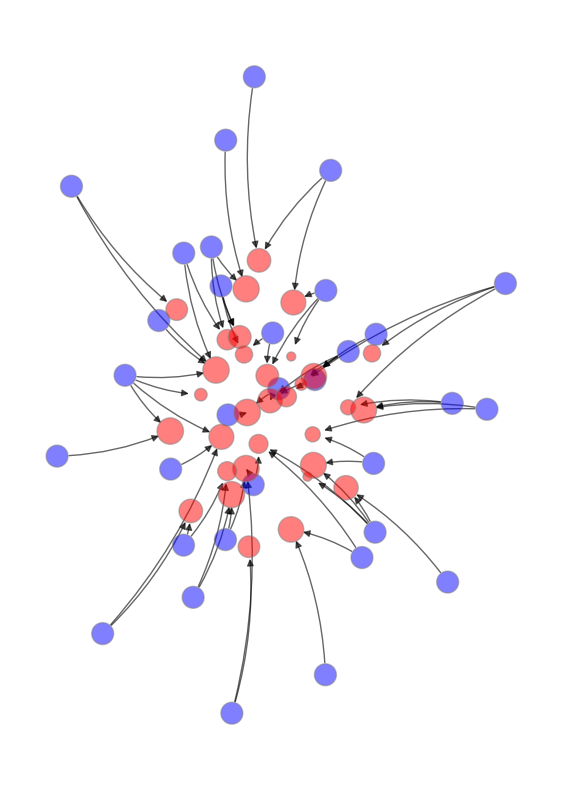

In [34]:
g = nx.DiGraph()
g.add_nodes_from([p.name for p in p_list])
g.add_nodes_from([q.name for q in q_list])

for i in range(n_p):
    for j in range(n_q):
        if pi[i, j] > 0:
            g.add_edge(p_list[i].name, q_list[j].name, weight=pi[i, j])

node_pos_dict={}
for p in p_list:
    node_pos_dict[p.name] = (p.x, p.y)

for q in q_list:
    node_pos_dict[q.name] = (q.x, q.y)

node_color_list = []
node_size_list = []
scale = 8_000
for p in p_list:
    node_color_list.append('blue')
    node_size_list.append(p.mass * scale)
for q in q_list:
    node_color_list.append('red')
    node_size_list.append(q.mass * scale)


fig, ax = plt.subplots(figsize=(7, 10))
plt.axis('off')

nx.draw_networkx_nodes(g, 
                       node_pos_dict, 
                       node_color=node_color_list,
                       node_size=node_size_list,
                       edgecolors='grey',
                       linewidths=1,
                       alpha=0.5,
                       ax=ax)

nx.draw_networkx_edges(g, 
                       node_pos_dict, 
                       arrows=True,
                       connectionstyle='arc3,rad=0.1',
                       alpha=0.6)
plt.show()
